In [ ]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
import keras 

In [ ]:
def showImage(arr):
    plt.imshow(arr, cmap = 'gray')
    plt.show()

In [ ]:
class BezierCurveLayer(tf.keras.layers.Layer):
    def __init__(self, num_control_points, img_acc, **kwargs):
        super(BezierCurveLayer, self).__init__(**kwargs)
        self.num_control_points = num_control_points
        self.img_acc = img_acc
        self.t = tf.linspace(0.0, 1.0, self.img_acc)
        self.bernstein = self._compute_bernstein()

    def _compute_bernstein(self):
        def binomial_coefficient(n, k):
            return tf.exp(tf.math.lgamma(tf.cast(n + 1, dtype=tf.float32)) - tf.math.lgamma(tf.cast(k + 1, dtype=tf.float32)) - tf.math.lgamma(tf.cast(n - k + 1, dtype=tf.float32)))
        
        def bernstein_polynomial(n, k, t):
            return binomial_coefficient(n, k) * tf.pow(t, tf.cast(k, dtype=tf.float32)) * tf.pow(1 - t, tf.cast(n - k, dtype=tf.float32))
        bernstein = tf.stack([bernstein_polynomial(self.num_control_points - 1, k, self.t) for k in range(self.num_control_points)], axis=-1)
        return tf.transpose(bernstein)
    
    def compute_image(self, t, grid_size, sigma):
        xv, yv = tf.meshgrid(tf.range(grid_size, dtype=tf.float32), tf.range(grid_size, dtype=tf.float32))
        grid_points = tf.stack([xv, yv], axis=-1)

        distances = tf.sqrt(tf.reduce_sum(tf.square(tf.expand_dims(grid_points, axis=2) - tf.expand_dims(t, axis=0)), axis=-1))
        weights = tf.exp(-distances / (2.0 * sigma ** 2))
        grid = tf.reduce_sum(weights, axis=-1)
        grid = tf.minimum(grid,1.0)
        grid = grid / tf.reduce_sum(grid)

        return grid


    def build(self, input_shape):
        super(BezierCurveLayer, self).build(input_shape)

    def call(self, inputs):

        batch_size = tf.shape(inputs)[0]
        control_points = tf.reshape(inputs, [batch_size, 2, self.num_control_points])
        bezier_curve = tf.matmul(control_points, self.bernstein)

        grid_size = 28.0
        sigma = 0.35

        bez = tf.transpose(bezier_curve, perm = (0,2,1)) * grid_size
        @tf.function
        def get_output_grid(grid_size,sigma,curve):
            return tf.map_fn(lambda t: self.compute_image(t, grid_size, sigma), curve)
        
        output_grid = get_output_grid(grid_size,sigma,bez)
        return output_grid



    def compute_output_shape(self, input_shape):
        return (input_shape[0], 28, 28)


pointsX = [0.362,1.173,0.714,-0.167,1.165,1.22,0.492,0.276]
pointsY = [0.12,0.167,0.41,0.282,0.594,0.493,1.033,0.603]

control_points = tf.reshape(tf.convert_to_tensor([[pointsX],[pointsY]]), (1,len(pointsX)*2))
bezier_layer = BezierCurveLayer(len(pointsX), img_acc=200)
output_image = bezier_layer(control_points)[0]


# Plot the output image
plt.imshow(output_image, cmap='gray')
plt.title('Bezier Curve Image')
plt.show()

train_im = output_image



latent_dim = 100

latent_dims = np.ones(shape=(100000, latent_dim))
image_to_replicate = np.array([train_im] * 100000)

generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9, clipvalue=10.0
)

In [ ]:
from keras.layers import Dense, Input, Reshape
from keras.models import Model
from keras.layers import LeakyReLU

def define_trainable(latent_dim):
    input_layer = Input(shape=(latent_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dense(16)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BezierCurveLayer(8, img_acc=200)(x)

    
    model = Model(input_layer, x)
    return model





generator = define_trainable(latent_dim=latent_dim)
generator.summary()


generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.KLDivergence())




In [ ]:
generator.fit(latent_dims, image_to_replicate, batch_size=32, epochs=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
(1, 28, 28)


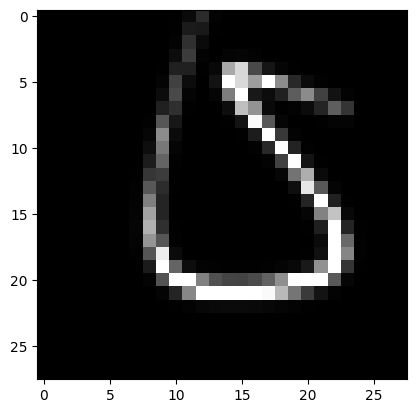

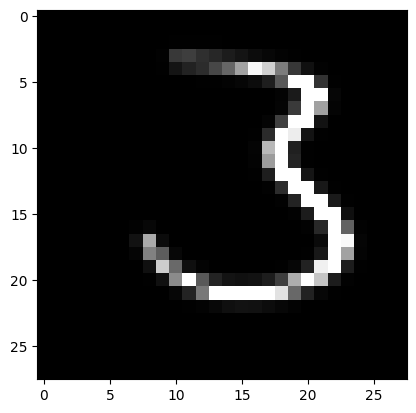

In [585]:
a = np.ones(shape=(1,latent_dim))
p = generator.predict(a)

print(p.shape)

showImage(p[0])
showImage(train_im)

In [ ]:
m = Model.save_weights(generator, filepath='generator_test.weights.h5')
def def_trainable(latent_dim):
    input_layer = Input(shape=(latent_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dense(16)(x)
    x = LeakyReLU(alpha=0.01)(x)
    model = Model(inputs=input_layer, outputs=x)
    return model



test_model = def_trainable(latent_dim)
test_model.compile(optimizer='adam', loss='mse')  # 
test_model.load_weights('/Users/seanyao/cs/ML Keras/generator_test.weights.h5')


print(test_model.predict(a)[0])
# showImage(train_im)
